# Optical Flow
1. Download Kitti Dataset
2. Implement Lucas-Kande Method
3. Implement Gunner Farneback Method
4. Flownet2-pytorch

# 1. Download Kitti Dataset 

In [ ]:
!curl https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0005/2011_09_26_drive_0005_sync.zip --output kitti.zip
!unzip kitti.zip
%pip install pyoptflow

import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import glob
import matplotlib.pyplot as plt

# 2. Implement Lucas-Kande Method
use six frames to show optical flow in last five frames.  
Use Shi-Tomasi algorithm to find strong corner to be feature first, and then use Lucas-Kande Method to find feature's optical flow frame by frame.

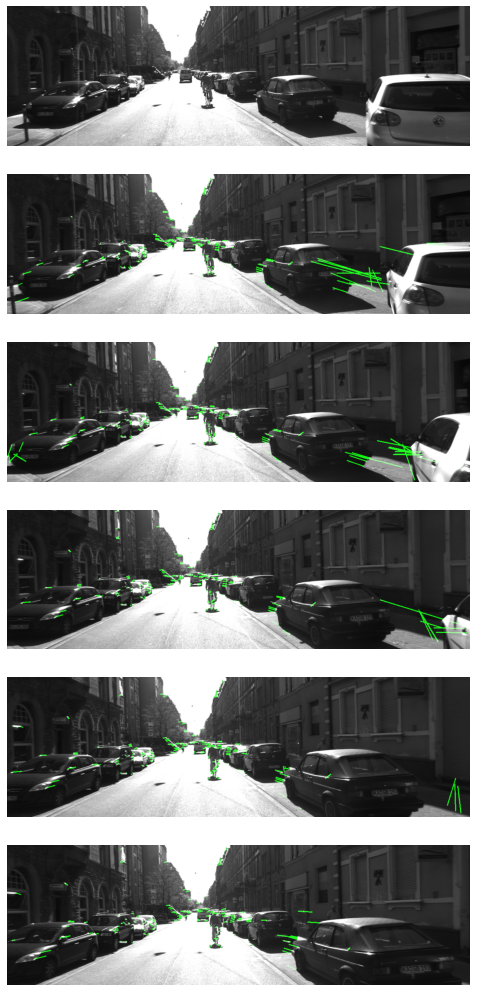

In [ ]:
def get_opicalflow_with_LK(frame1, frame2):
  '''
  return correspond point in each frame
  inputs:  
    frame1: previos frame, grayscale image  
    frame2: next frame, grayscale image  
  outputs:  
    correspond points in frame1: 2d array, point in each row
    correspond points in frame2: 2d array, point in each row
  '''
  feature_params = dict(maxCorners=300, qualityLevel=0.2, minDistance=2, blockSize=7)
  lk_params = dict(winSize = (15,15), maxLevel = 2, criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))
  # get strong corners in frame1
  corner_feature_f1 = cv2.goodFeaturesToTrack(frame1, mask=None, **feature_params)
  # caculate corespond point in frame2
  next, status, error = cv2.calcOpticalFlowPyrLK(frame1, frame2, corner_feature_f1, None, **lk_params)
  return corner_feature_f1[status == 1], next[status == 1]

def viualize_opticalflow_LK(frame2, good_feature_f1, good_feature_f2):
  '''
  viualize opticalflow, draw line with correspond points in frame2, draw a circle at feature in frame2
  inputs:
    frame2: ndarray, RGB image
    good_feature_f1: feature in frame1, same length as good_feature_f2
    good_feature_f2: feature in frame2
  outputs:
    frame2 after viualized opticalflow
  '''
  color = (0,225,0)
  mask = np.zeros_like(frame2)
  frame2_grey = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
  for i, (feature_f1, feature_f2) in enumerate(zip(good_feature_f1, good_feature_f2)):
    a, b = feature_f1.ravel()
    c, d = feature_f2.ravel()
    mask = cv2.line(mask, (a, b), (c, d), color, 2)
    frame2_grey = cv2.circle(frame2_grey, (a, b), 3, color, -1)
    output = cv2.add(frame2, mask)
  return output

def img_pth_generator():
  ''' generate image path '''
  g = glob.iglob("/content/2011_09_26/2011_09_26_drive_0005_sync/image_00/data/000000014[0-5].png")
  for pth in sorted(g):
    yield pth


genr = img_pth_generator()
frame1 = None
f = plt.figure(figsize=(24,18))
count = 0
while count < 5:
  if frame1 is None:
    frame1 = cv2.imread(next(genr))
    plt.subplot(6,1,1)
    plt.imshow(frame1)
    plt.axis("off")

  frame2 = cv2.imread(next(genr))
  good_feature_f1, good_feature_f2 = get_opicalflow_with_LK(cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY), cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY))
  out = viualize_opticalflow_LK(frame2, good_feature_f1, good_feature_f2)
  frame1 = frame2
  plt.subplot(6,1,count+2)
  plt.imshow(out)
  plt.axis("off")
  count += 1
plt.show()


# 3. Implement Gunner Farneback Method


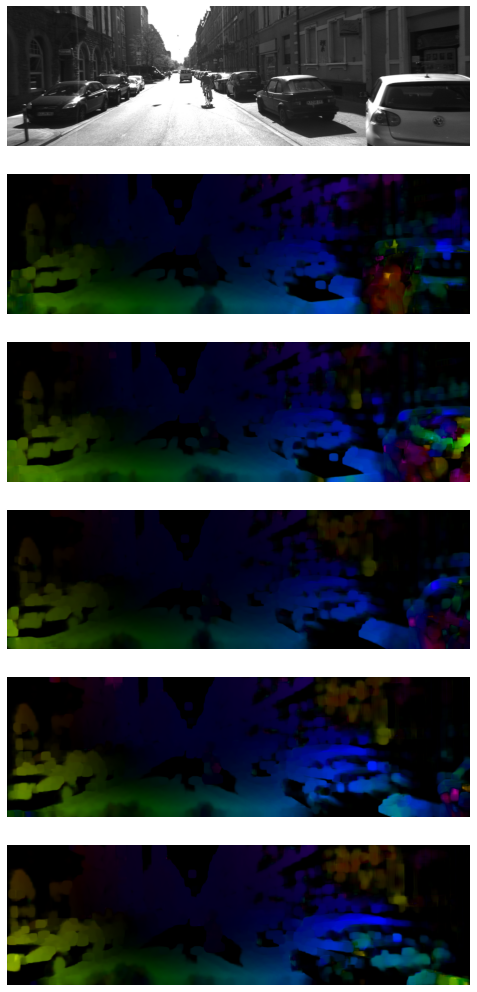

In [ ]:
def viualize_opticalflow_GF(frame1, frame2):
  '''
  calculate optical flow(global) by Gunner Farneback Method, and visualize it.
  inputs:
    frame1: ndarray, rgb image, previous frame.
    frame2: ndarray, rgb image, next frame.
  output:
    3d array, rgg image
  '''
  hsv = np.zeros_like(frame1)
  hsv[..., 1] = 255
  flow = cv2.calcOpticalFlowFarneback(cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY), cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY), None, 0.5, 3, 15, 3, 5, 1.2, 0)
  mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
  hsv[..., 0] = ang * 180 / np.pi / 2
  hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
  return cv2.cvtColor(hsv,cv2.COLOR_HSV2BGR)

genr = img_pth_generator()
frame1 = None
f = plt.figure(figsize=(24,18))
count = 0
while count < 5:
  if frame1 is None:
    frame1 = cv2.imread(next(genr))
    plt.subplot(6,1,1)
    plt.imshow(frame1)
    plt.axis("off")

  frame2 = cv2.imread(next(genr))
  out = viualize_opticalflow_GF(frame1, frame2)
  frame1 = frame2
  plt.subplot(6,1,count+2)
  plt.imshow(out)
  plt.axis("off")
  count += 1
plt.show()

#4. Flownet2-pytorch
i. Setup and Install FlowNet2  
a. Download compatible Torch   
b. Download and setup FlowNet2 files  
ii. Download files and Install Packages  
iii. Run the inference  
iv. Visualizing flo files  
v. Warp Images using flow

## i. Setup and Install FlowNet2
a. Download compatible Torch  
b. Download and setup FlowNet2 files  

### a. Download compatible Torch

In [ ]:
!pip install torch==1.0.0 torchvision==0.2.2 -f https://download.pytorch.org/whl/cu90/torch_stable.html

### b. Download and setup FlowNet2 files

In [ ]:
import os
# get flownet2-pytorch source
!git clone https://github.com/Gauravv97/flownet2-pytorch.git
!mv /content/flownet2-pytorch /content/flownet2pytorch
os.chdir('./flownet2pytorch')
# install custom layers
!bash install.sh

#### Add packages to IPython system path

In [ ]:
import os
os.sys.path.append('/root/.local/lib/python3.6/site-packages/resample2d_cuda-0.0.0-py3.6-linux-x86_64.egg')
os.sys.path.append('/root/.local/lib/python3.6/site-packages/correlation_cuda-0.0.0-py3.6-linux-x86_64.egg')
os.sys.path.append( '/root/.local/lib/python3.6/site-packages/channelnorm_cuda-0.0.0-py3.6-linux-x86_64.egg')

## ii. Download files and Install Packages

In [ ]:
!pip install pypng
!pip install tensorboardx
!pip install  setproctitle colorama scipy==1.1.0

     |████████████████████████████████| 655kB 12.2MB/s 


In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='1hF8vS6YeHkx3j2pfCeQqqZGwA_PJq_Da',dest_path='./FlowNet2_checkpoint.pth.tar')

## iii. Run the inference

#### Downloading sample video. You can upload your own video named video.mp4 in the folder flownet2pytorch

In [ ]:
gdd.download_file_from_google_drive(file_id='18kfA8pQyXCN-Tk6HREbgZL6mKPttJ3cg',dest_path='./video.mp4')

#### Converting video to frames

In [ ]:
import os
def mkdir_ifnotexists(dir):
    if os.path.exists(dir):
        return
    os.mkdir(dir)

In [ ]:
vid_file='./video.mp4'
frame_pth='./frames'
mkdir_ifnotexists(frame_pth)
cmd = "ffmpeg -i %s -start_number 0 -vsync 0 %s/frame_%%06d.png" % (
            vid_file,
            frame_pth,
        )
os.system(cmd)

0

#### Generate .flo files using FlowNet2

In [ ]:
!python main.py --inference --model FlowNet2 --save_flow --save ./output --inference_dataset ImagesFromFolder --inference_dataset_root ./frames/ --resume ./FlowNet2_checkpoint.pth.tar

Parsing Arguments
  [0.032s] batch_size: 8
  [0.032s] crop_size: [256, 256]
  [0.032s] fp16: False
  [0.032s] fp16_scale: 1024.0
  [0.032s] gradient_clip: None
  [0.032s] inference: True
  [0.032s] inference_batch_size: 1
  [0.032s] inference_dataset: ImagesFromFolder
  [0.032s] inference_dataset_iext: png
  [0.032s] inference_dataset_replicates: 1
  [0.032s] inference_dataset_root: ./frames/
  [0.032s] inference_n_batches: -1
  [0.032s] inference_size: [-1, -1]
  [0.032s] inference_visualize: False
  [0.032s] log_frequency: 1
  [0.032s] loss: L1Loss
  [0.032s] model: FlowNet2
  [0.032s] model_batchNorm: False
  [0.032s] model_div_flow: 20.0
  [0.032s] name: run
  [0.032s] no_cuda: False
  [0.032s] number_gpus: 1
  [0.032s] number_workers: 8
  [0.032s] optimizer: Adam
  [0.032s] optimizer_amsgrad: False
  [0.032s] optimizer_betas: (0.9, 0.999)
  [0.032s] optimizer_eps: 1e-08
  [0.032s] optimizer_lr: 0.001
  [0.032s] optimizer_weight_decay: 0
  [0.032s] render_validation: False
  [0.032

## iv. Visualizing flo files

#### Install scipy as some tensorflow functionality requires updated scipy

In [ ]:
!pip install scipy==1.4.1

     |████████████████████████████████| 26.1MB 125kB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.1.0
    Uninstalling scipy-1.1.0:
      Successfully uninstalled scipy-1.1.0


In [ ]:
os.chdir('/content/flownet2pytorch')

#### Define show_flow() for visualization.
 Original Source https://github.com/sampepose/flownet2-tf/blob/master/src/flowlib.py

In [ ]:
# Source:https://github.com/sampepose/flownet2-tf/blob/master/src/flowlib.py
import matplotlib.pyplot as plt
import numpy as np

UNKNOWN_FLOW_THRESH = 1e7
def show_flow(filename):
    """
    visualize optical flow map using matplotlib
    :param filename: optical flow file
    :return: None
    """
    flow = read_flow(filename)
    img = flow_to_image(flow)
    plt.imshow(img)
    plt.show()

def read_flow(filename):
    """
    read optical flow from Middlebury .flo file
    :param filename: name of the flow file
    :return: optical flow data in matrix
    """
    f = open(filename, 'rb')
    magic = np.fromfile(f, np.float32, count=1)
    data2d = None

    if 202021.25 != magic:
        print ('Magic number incorrect. Invalid .flo file')
    else:
        w = int(np.fromfile(f, np.int32, count=1)[0])
        h = int(np.fromfile(f, np.int32, count=1)[0])
        #print("Reading %d x %d flo file" % (h, w))
        data2d = np.fromfile(f, np.float32, count=2 * w * h)
        # reshape data into 3D array (columns, rows, channels)
        data2d = np.resize(data2d, (h, w, 2))
    f.close()
    return data2d

def flow_to_image(flow):
    """
    Convert flow into middlebury color code image
    :param flow: optical flow map
    :return: optical flow image in middlebury color
    """
    u = flow[:, :, 0]
    v = flow[:, :, 1]

    maxu = -999.
    maxv = -999.
    minu = 999.
    minv = 999.

    idxUnknow = (abs(u) > UNKNOWN_FLOW_THRESH) | (abs(v) > UNKNOWN_FLOW_THRESH)
    u[idxUnknow] = 0
    v[idxUnknow] = 0

    maxu = max(maxu, np.max(u))
    minu = min(minu, np.min(u))

    maxv = max(maxv, np.max(v))
    minv = min(minv, np.min(v))

    rad = np.sqrt(u ** 2 + v ** 2)
    maxrad = max(-1, np.max(rad))

    #print( "max flow: %.4f\nflow range:\nu = %.3f .. %.3f\nv = %.3f .. %.3f" % (maxrad, minu,maxu, minv, maxv))

    u = u/(maxrad + np.finfo(float).eps)
    v = v/(maxrad + np.finfo(float).eps)

    img = compute_color(u, v)

    idx = np.repeat(idxUnknow[:, :, np.newaxis], 3, axis=2)
    img[idx] = 0

    return np.uint8(img)


def compute_color(u, v):
    """
    compute optical flow color map
    :param u: optical flow horizontal map
    :param v: optical flow vertical map
    :return: optical flow in color code
    """
    [h, w] = u.shape
    img = np.zeros([h, w, 3])
    nanIdx = np.isnan(u) | np.isnan(v)
    u[nanIdx] = 0
    v[nanIdx] = 0

    colorwheel = make_color_wheel()
    ncols = np.size(colorwheel, 0)

    rad = np.sqrt(u**2+v**2)

    a = np.arctan2(-v, -u) / np.pi

    fk = (a+1) / 2 * (ncols - 1) + 1

    k0 = np.floor(fk).astype(int)

    k1 = k0 + 1
    k1[k1 == ncols+1] = 1
    f = fk - k0

    for i in range(0, np.size(colorwheel,1)):
        tmp = colorwheel[:, i]
        col0 = tmp[k0-1] / 255
        col1 = tmp[k1-1] / 255
        col = (1-f) * col0 + f * col1

        idx = rad <= 1
        col[idx] = 1-rad[idx]*(1-col[idx])
        notidx = np.logical_not(idx)

        col[notidx] *= 0.75
        img[:, :, i] = np.uint8(np.floor(255 * col*(1-nanIdx)))

    return img


def make_color_wheel():
    """
    Generate color wheel according Middlebury color code
    :return: Color wheel
    """
    RY = 15
    YG = 6
    GC = 4
    CB = 11
    BM = 13
    MR = 6

    ncols = RY + YG + GC + CB + BM + MR

    colorwheel = np.zeros([ncols, 3])

    col = 0

    # RY
    colorwheel[0:RY, 0] = 255
    colorwheel[0:RY, 1] = np.transpose(np.floor(255*np.arange(0, RY) / RY))
    col += RY

    # YG
    colorwheel[col:col+YG, 0] = 255 - np.transpose(np.floor(255*np.arange(0, YG) / YG))
    colorwheel[col:col+YG, 1] = 255
    col += YG

    # GC
    colorwheel[col:col+GC, 1] = 255
    colorwheel[col:col+GC, 2] = np.transpose(np.floor(255*np.arange(0, GC) / GC))
    col += GC

    # CB
    colorwheel[col:col+CB, 1] = 255 - np.transpose(np.floor(255*np.arange(0, CB) / CB))
    colorwheel[col:col+CB, 2] = 255
    col += CB

    # BM
    colorwheel[col:col+BM, 2] = 255
    colorwheel[col:col+BM, 0] = np.transpose(np.floor(255*np.arange(0, BM) / BM))
    col += + BM

    # MR
    colorwheel[col:col+MR, 2] = 255 - np.transpose(np.floor(255 * np.arange(0, MR) / MR))
    colorwheel[col:col+MR, 0] = 255

    return colorwheel

#### Visualize

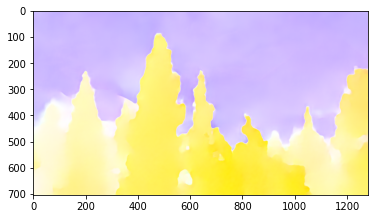

In [ ]:
show_flow('/content/flownet2pytorch/output/inference/run.epoch-0-flow-field/000002.flo')

#### Save Flo files as images

In [ ]:
import os
import PIL.Image
def mkdir_ifnotexists(dir):
    if os.path.exists(dir):
        return
    os.mkdir(dir)


flo_pth='/content/flownet2pytorch/output/inference/run.epoch-0-flow-field/'
flos=[flo_pth + f for f in os.listdir(flo_pth)]
mkdir_ifnotexists('./FlowFrames')
for i in range(len(flos)):
 PIL.Image.fromarray(flow_to_image(read_flow(flos[i]))).save('./FlowFrames/'+os.path.basename(flos[i])+'.png')

#### Generate video from Flo

In [ ]:
os.system('ffmpeg -r 24 -i FlowFrames/%6d.flo.png -vcodec libx264 -b 10M -y FlowVideo.mp4  ')

0

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('FlowVideo.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## v. Warp Images using flow

In [ ]:
import tensorflow as tf
import PIL.Image
import numpy as np
def load_img(path_to_img,max_dim = 0):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim
  if max_dim==0:
      scale=1
  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img
def tensor_to_image(tensor):
  tensor = tensor
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

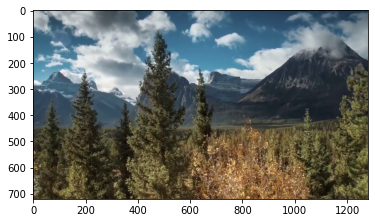

In [ ]:
import tensorflow_addons as tfa
i=0
frames=['frames/' + f for f in os.listdir('./frames/')]
frames.sort()
input_img = load_img(frames[1])
#if image/frame size is not divisible by 2e5 then the generated flow size will be smaller and divisible by 2e5
#resize the flow to frame size
flo_pth='/content/flownet2pytorch/output/inference/run.epoch-0-flow-field/'
flos=[flo_pth + f for f in os.listdir(flo_pth)]
flos.sort()
flow=tf.image.resize(read_flow(flos[1]),input_img.shape[1:3],method='bilinear')
plt.imshow(tensor_to_image(tfa.image.dense_image_warp( input_img, tf.expand_dims(flow,0))*255))

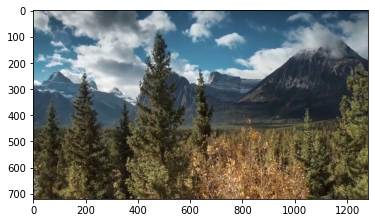

In [ ]:
plt.imshow(tensor_to_image(load_img(frames[1])*255))

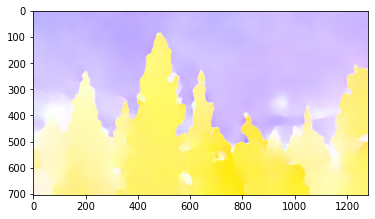

In [ ]:
show_flow(flos[1])